In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Redditors opinion on Israel-Palestine War/posts.csv
/kaggle/input/Redditors opinion on Israel-Palestine War/reddit_comments_clean.csv


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import warnings

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

# Introduction to the Dataset: Redditors' Comments on the Israel-Palestine War

This dataset contains Reddit posts and comments related to the ongoing Israel-Palestine conflict. The data provides insights into the public's perception, opinions, and sentiments about the war, offering valuable information for sentiment analysis, topic modeling, and trend analysis over time.

## Dataset Overview

### 1. Posts Dataset (`posts.csv`):
Contains details about Reddit posts discussing the Israel-Palestine conflict.

**Key Columns:**
- `post_id`: Unique identifier for each post.
- `title`: The title of the post.
- `author`: The Reddit user who created the post.
- `subreddit`: The subreddit where the post was published.
- `created_utc`: Timestamp indicating when the post was created.
- `score`: The number of upvotes the post received.
- `num_comments`: Number of comments on the post.
- `text`: The content of the post.

---

### 2. Comments Dataset (`reddit_comments_clean.csv`):
Contains comments made on the Reddit posts discussing the conflict.

**Key Columns:**
- `comment_id`: Unique identifier for each comment.
- `post_id`: Identifier linking the comment to its respective post.
- `author`: The Reddit user who wrote the comment.
- `created_utc`: Timestamp indicating when the comment was created.
- `body`: The content of the comment.
- `score`: The number of upvotes the comment received.
- `sentiment`: (Optional) Precomputed sentiment score for the comment.

---

## Objective
The goal of analyzing this dataset is to understand the dynamics of public opinion on Reddit regarding the Israel-Palestine conflict. Potential analyses include:

- **Sentiment Analysis:** Identify positive, negative, or neutral sentiments in posts and comments.
- **Topic Modeling:** Discover key themes and topics discussed by Redditors.
- **Trend Analysis:** Examine how the conversation evolves over time.
- **Engagement Analysis:** Measure user engagement based on upvotes and the number of comments.


In [6]:
import pandas as pd

# Replace 'your-dataset-folder' with the actual folder name displayed by the code above
posts_path = '/kaggle/input/Redditors opinion on Israel-Palestine War/posts.csv'
comments_path = '/kaggle/input/Redditors opinion on Israel-Palestine War/reddit_comments_clean.csv'

# Load the CSV files
posts_df = pd.read_csv(posts_path)
comments_df = pd.read_csv(comments_path)


In [7]:
posts_df.head()

,class,id,num_comments,preview,subreddit,text,timestamp,title,upvote_ratio,upvotes,url
0,NaN,175au9w,682,https://external-preview.redd.it/35qaia1zr0YPI...,r/geopolitics,NaN,2023-10-11 11:31:27,Is this Palestine-Israel map history accurate?,0.77,1060,https://solidarnost.su/wp-content/uploads/2015...
1,NaN,1c7lqqt,1375,https://external-preview.redd.it/mKqHVAGaLWiUI...,r/news,NaN,2024-04-19 03:26:18,Israel missiles strike Iran - US officials inf...,0.94,11643,https://www.reuters.com/world/middle-east/isra...
2,NaN,1c3pjmi,1492,NaN,r/NoStupidQuestions,Aren't they Jewish? Don't they specifically NO...,2024-04-14 10:26:07,"Why do Christian nationalists support Israel, ...",0.77,6048,https://www.reddit.com/r/NoStupidQuestions/com...
3,NaN,175v330,456,NaN,r/geopolitics,Basically the question above. I understand the...,2023-10-12 02:44:41,Why is Israel so significant for the West ?,0.87,366,https://www.reddit.com/r/geopolitics/comments/...
4,palestisrael,1c3aiv5,5143,https://external-preview.redd.it/8bwtWtE4wx8uq...,r/worldnews,NaN,2024-04-13 19:53:25,Iran launched dozens of drones toward Israel -...,0.91,28884,https://www.jpost.com/breaking-news/article-79...


In [8]:
comments_df.head()

,post_id,id,label,text,timestamp,ups
0,175au9w,k4efycz,neutral,Israel pulled out of Gaza in 2005 so the 2010 ...,2023-10-11 11:56:11,1411
1,175au9w,k4eg0gi,with palestine,The 1946 map should be completely red as the w...,2023-10-11 11:56:49,833
2,175au9w,k4ees0u,with palestine,To be fair. You should count 1947 as the first...,2023-10-11 11:43:13,457
3,175au9w,k4eke8z,with israel,No. Each map is depicting something different....,2023-10-11 12:41:04,217
4,175au9w,k4eipaq,with israel,"A history of Israel over the last 100 years, i...",2023-10-11 12:24:44,168


## Data Preprocessing

In [9]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   class         726 non-null    object 
 1   id            2802 non-null   object 
 2   num_comments  2802 non-null   int64  
 3   preview       2307 non-null   object 
 4   subreddit     2802 non-null   object 
 5   text          551 non-null    object 
 6   timestamp     2802 non-null   object 
 7   title         2802 non-null   object 
 8   upvote_ratio  2802 non-null   float64
 9   upvotes       2802 non-null   int64  
 10  url           2802 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 240.9+ KB


# Merge DataFrames and Prepare the Final Dataset

In this section, we will:
1. Merge the `posts_df` and `comments_df` dataframes.
2. Create a new column called `sentence` that combines the post and comment text.
3. Transform the labels by consolidating similar categories.
4. Calculate the length of each sentence.
5. Encode the labels for machine learning purposes.
6. Display a random sample of the final dataset.

---

In [10]:
# Merge DataFrames
merged_df = pd.merge(comments_df, posts_df, left_on='post_id', right_on='id', how='inner')

# Create sentences directly using a lambda function and conditional logic
merged_df["sentence"] = merged_df.apply(lambda row: f"title of the post: {row['title']}\npost: {row['text_y']}\ncomment: {row['text_x']}" 
                                       if pd.notnull(row['text_y']) else f"title of the post: {row['title']}\ncomment: {row['text_x']}", axis=1)

# Apply label transformation directly
merged_df["label"] = merged_df["label"].apply(lambda x: "neutral" if x in ["indifferent", "inquisitive"] else x)

# Calculate sentence length
merged_df["len_sentence"] = merged_df["sentence"].apply(lambda x: len(x.strip()))

# Encode labels using map
labels = merged_df['label'].unique()
label2id = {value: key for key, value in enumerate(labels)}
merged_df["encoded_label"] = merged_df["label"].map(label2id)

# Now, merged_df contains the final dataset
merged_df.sample(3)


,post_id,id_x,label,text_x,timestamp_x,ups,class,id_y,num_comments,preview,subreddit,text_y,timestamp_y,title,upvote_ratio,upvotes,url,sentence,len_sentence,encoded_label
21298,1bevr4p,kv22z5e,with israel,These antisemites (Jew-Haters) are helping me ...,2024-03-15 22:10:01,3,meme,1bevr4p,57,https://preview.redd.it/y0a3rjsx4doc1.jpeg?aut...,r/Israel,NaN,2024-03-14 20:53:54,I’m sorry for all South Africans here,0.96,1053,https://i.redd.it/y0a3rjsx4doc1.jpeg,title of the post: I’m sorry for all South Afr...,169,2
24913,17ibowg,k6t4fif,with israel,And that's the nasty bit. \n\n\nIsrael was at...,2023-10-28 12:54:46,330,palestisrael,17ibowg,2780,https://external-preview.redd.it/jHd81G5BUNuQZ...,r/worldnews,NaN,2023-10-28 12:22:45,"New York Times: Hamas' stockpiles of fuel, foo...",0.83,15116,https://www.nytimes.com/2023/10/27/world/middl...,title of the post: New York Times: Hamas' stoc...,2040,2
19087,15z2l9o,jxf0j9p,neutral,It's almost like it's an extremely nuanced iss...,2023-08-23 15:30:33,321,NaN,15z2l9o,163,https://preview.redd.it/ogu5y6zktujb1.png?auto...,r/HistoryMemes,NaN,2023-08-23 13:33:08,They all think that they'll be the one to do i...,0.99,6711,https://i.redd.it/ogu5y6zktujb1.png,title of the post: They all think that they'll...,193,0


In [11]:
print(merged_df["label"].value_counts())

label
with palestine    9130
with israel       9052
neutral           8136
Name: count, dtype: int64


## Distribution of Labels (Categorical Distribution)

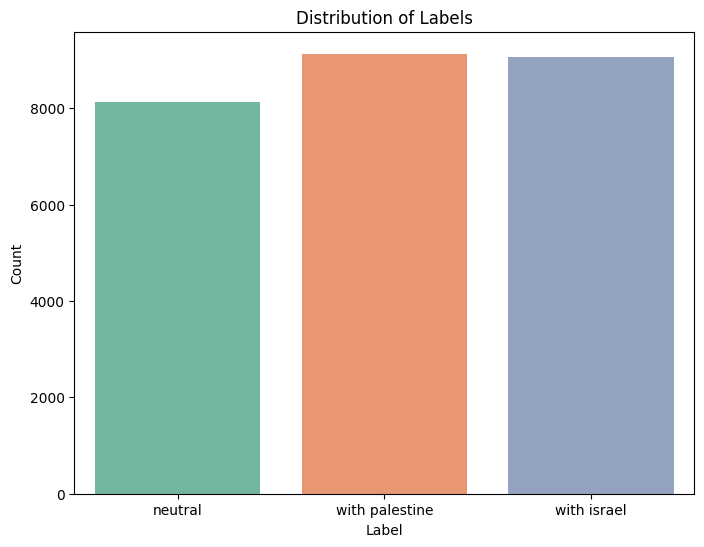

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of labels
plt.figure(figsize=(8,6))
sns.countplot(data=merged_df, x='label', palette='Set2')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


## Distribution of Sentence Lengths (Numerical Distribution)

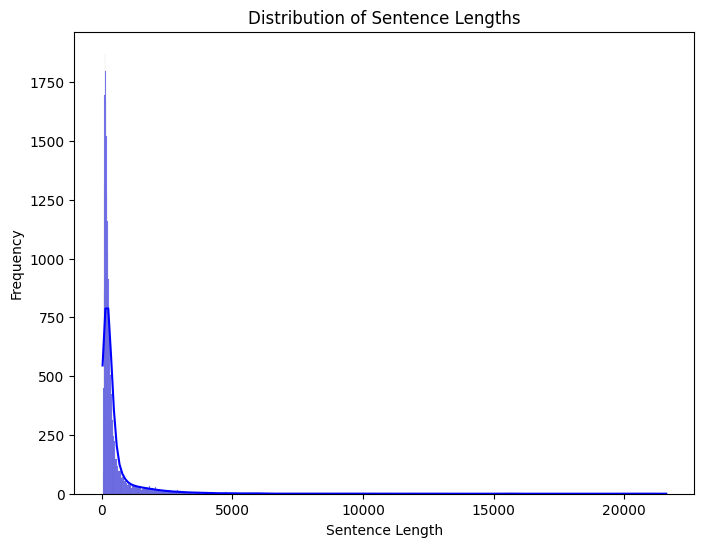

In [13]:
# Plot the distribution of sentence lengths
plt.figure(figsize=(8,6))
sns.histplot(merged_df['len_sentence'], kde=True, color='blue')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()


## Text Preprocessing and Data Preparation for Machine Learning

In this section, we will prepare the data for training a machine learning model. This includes:
1. Tokenizing the text data in the `sentence` column.
2. Padding the sequences to ensure they are all of the same length.
3. One-hot encoding the labels.
4. Splitting the data into training and testing sets.

---

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # For one-hot encoding



# 1. Tokenize the sentences in 'sentence' column of merged_df
max_features = 10000  # Number of words to consider as features
max_len = 500  # Cut texts after this number of words

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(merged_df['sentence'])

# Convert the sentences into sequences of integers
x = tokenizer.texts_to_sequences(merged_df['sentence'])

# 2. Pad sequences (to a fixed length of `max_len`)
x = sequence.pad_sequences(x, maxlen=max_len)

# 3. Prepare labels (y_train, y_test)
# Directly apply one-hot encoding to the 'label' column
y = merged_df['label']  # This should contain the text labels: "Palestine", "Israel", "Neutral"

# 4. One-hot encode the labels directly
y = pd.get_dummies(y)  # Convert categorical labels to one-hot encoded labels

# 5. Split data into train and test sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Display the shapes of the data
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


x_train shape: (21054, 500)
x_test shape: (5264, 500)
y_train shape: (21054, 3)
y_test shape: (5264, 3)


In [19]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Model Building and Training

In this section, we will build and train a Convolutional Neural Network (CNN) model for text classification. We will use the following components:
1. **Embedding layer**: To represent words as dense vectors.
2. **Convolutional layers**: To capture local patterns in the text data.
3. **Pooling layers**: To downsample and reduce dimensionality.
4. **Dense layer**: For the final classification.
5. **Callbacks**: For early stopping and learning rate scheduling.

---

In [20]:
model = Sequential()
model.add(layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))  # Specify input_length
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(3, activation='softmax'))  # 3 classes
model.build(input_shape=(None, max_len))  # Build the model
model.summary()



model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',    # we are using 3 classes in output
              metrics=['accuracy'])

# Early stopping and learning rate scheduler callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',      # or 'val_accuracy'
    patience=3,              # Number of epochs with no improvement to stop training
    restore_best_weights=True,  # Restore the best model weights at the end of training
    verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)


history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=128,
                    callbacks=[early_stopping ,lr_scheduler],
                    validation_split=0.2)




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 494, 32)        │        28,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 98, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 92, 32)         │         7,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,316,003 (5.02 MB)

 Trainable params: 1,316,003 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1733345708.007764      76 service.cc:145] XLA service 0x7cf1ac0036e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733345708.007826      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/132 ━━━━━━━━━━━━━━━━━━━━ 8:25 4s/step - accuracy: 0.3906 - loss: 1.0941

I0000 00:00:1733345710.829164      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 176ms/step - accuracy: 0.3552 - loss: 1.0948 - val_accuracy: 0.3783 - val_loss: 1.0901 - learning_rate: 1.0000e-04
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.3970 - loss: 1.0892 - val_accuracy: 0.4196 - val_loss: 1.0868 - learning_rate: 1.0000e-04
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 204ms/step - accuracy: 0.4588 - loss: 1.0834 - val_accuracy: 0.4408 - val_loss: 1.0825 - learning_rate: 1.0000e-04
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 25s 191ms/step - accuracy: 0.4752 - loss: 1.0779 - val_accuracy: 0.4633 - val_loss: 1.0766 - learning_rate: 1.0000e-04
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.4835 - loss: 1.0716 - val_accuracy: 0.4704 - val_loss: 1.0678 - learning_rate: 1.0000e-04
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.5048 - loss: 1.0579 - val_accuracy: 0.4856 - val_loss: 1.0538 - learning_rate: 1.0000e-04
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/s

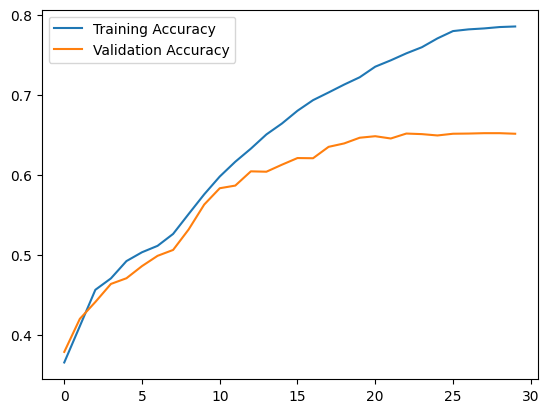

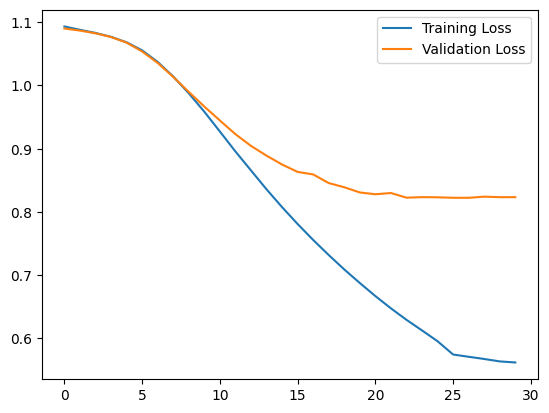

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


# Simple Insights from Model Training

# 1. Accuracy Improvements
The training accuracy has steadily increased from around 74.74% at Epoch 24 to about 78.68% at Epoch 28, 
indicating the model is learning and improving over time.

# 2. Validation Accuracy
The validation accuracy fluctuates around 65%, suggesting that the model's generalization on the validation set 
is not improving significantly. This may indicate the need for further adjustments to the model or the data.

# 3. Loss Trends
The training loss decreases from 0.6366 at Epoch 24 to 0.5584 at Epoch 28, which is a positive sign that the 
model is learning to predict better.
However, the validation loss shows very little improvement and even fluctuates, suggesting the model might 
be overfitting or struggling to generalize well on the validation set.

# 4. Learning Rate Adjustment
The learning rate starts at 1e-4 and gradually reduces to 1e-5 due to the ReduceLROnPlateau callback. 
This is done to fine-tune the model when it shows signs of plateauing.

# 5. Early Stopping
Early stopping was triggered at Epoch 30 because the validation loss did not improve for a certain number of epochs. 
The best model (at Epoch 27) was restored, preventing the model from overfitting to the training data.

# Summary:
- The model shows improving training accuracy but struggles with validation accuracy.
- The loss for both training and validation decreased, but validation loss did not improve significantly.
- Early stopping helped prevent overfitting by stopping training when validation performance plateaued.


In [25]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions from the model
y_pred_prob = model.predict(x_test)

# Convert predicted probabilities to class labels (one-hot to class index)
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert y_test (DataFrame) to class indices if it's one-hot encoded
y_true = np.argmax(y_test.values, axis=1)  # Fixing the original error

# Generate and display the classification report
print(classification_report(y_true, y_pred, target_names=["with_palestine", "with_israel", "neutral"]))


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                precision    recall  f1-score   support

with_palestine       0.65      0.66      0.65      1631
   with_israel       0.66      0.65      0.66      1816
       neutral       0.67      0.68      0.67      1817

      accuracy                           0.66      5264
     macro avg       0.66      0.66      0.66      5264
  weighted avg       0.66      0.66      0.66      5264



In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


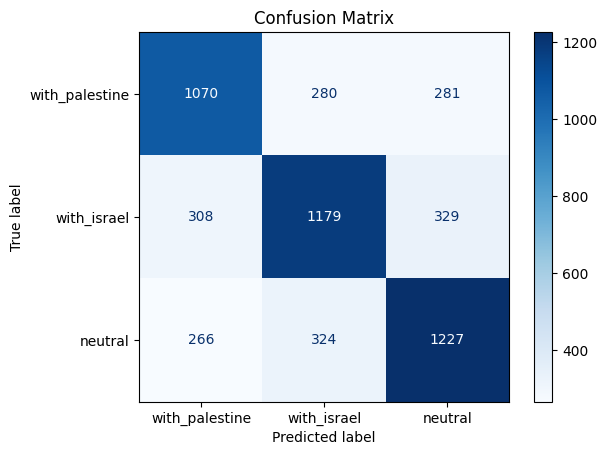

In [27]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["with_palestine", "with_israel", "neutral"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Insights from Classification Results

## 1. Class-wise Performance:
- **With Palestine**: The model achieved an accuracy of 65% for this class. The precision, recall, and F1-score are quite close to each other, indicating balanced performance for this class.
- **With Israel**: The accuracy for this class is slightly better at 66%. The precision and recall values are also close, showing that the model is performing well in distinguishing this class.
- **Neutral**: The model performs similarly on the neutral class with a precision of 67%, recall of 68%, and F1-score of 67%, which is slightly better than the other two classes.

## 2. Overall Accuracy:
- The **overall accuracy** of the model is 66%, meaning the model is correctly classifying about two-thirds of the instances. This is reasonable, but there is room for improvement in fine-tuning or adjusting the model to better handle specific classes.

## 3. Macro Average:
- The **macro average** values for precision, recall, and F1-score are all 66%, which suggests that the model treats all classes equally in terms of performance. It doesn't show a significant bias toward any particular class.

## 4. Weighted Average:
- The **weighted average** values are also 66%, indicating that the model performs consistently across all classes, even when considering the imbalance in the number of samples per class (e.g., "with Israel" has 1816 instances, while "neutral" has 1817).

## Key Insights:
- The model performs reasonably well across all classes, with similar precision, recall, and F1-scores for "with Palestine," "with Israel," and "neutral."
- There's no major class imbalance affecting performance since the results show consistent accuracy across different metrics.
- The overall accuracy of 66% shows that there's room for improvement, either by tuning the model, adding more features, or adjusting the training data.

### Recommendations:
Further optimization and fine-tuning may be necessary to boost the overall performance.


------------
